In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

# Visualising the data


2024-10-23 19:08:31.070407: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-23 19:08:31.119678: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-23 19:08:31.208129: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-23 19:08:31.374290: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


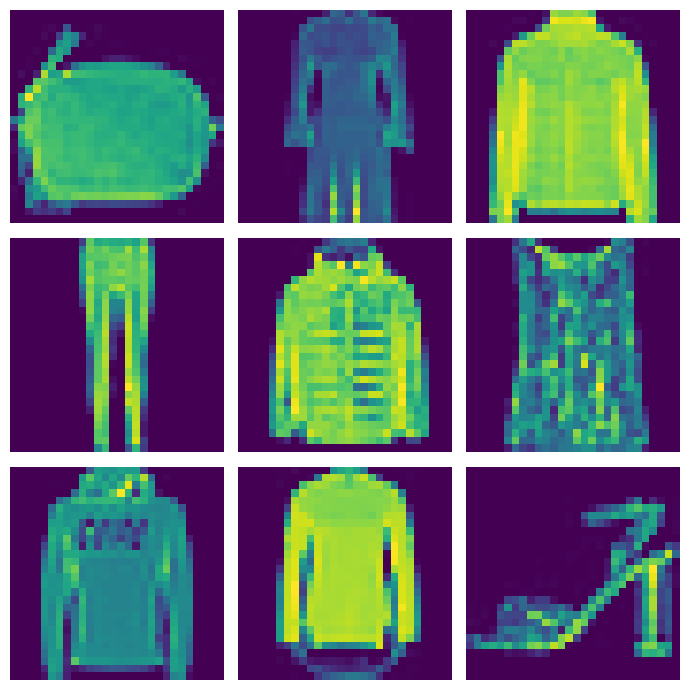

In [2]:
batch_size = 128
dataset = tfds.load("fashion_mnist", split="train", batch_size=batch_size, shuffle_files=True,  as_supervised=True)
dataset = dataset.shuffle(buffer_size=1024)
length = len(dataset)

import random

rand_batch_index = random.randint(0, length-1)
selected_batch = dataset.skip(rand_batch_index).take(1)
rand_image_index = random.randint(0, batch_size-1)

plt.figure(figsize=(7, 7))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    for batch in selected_batch:
        image_batch, label_batch = batch
        ax.imshow(image_batch.numpy()[rand_image_index])
        ax.axis(False)

plt.tight_layout()
plt.show()

In [3]:
def scale_images(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Ensure the image is float before division
    return image, label

dataset = dataset.map(scale_images)
dataset = dataset.take(1024)
dataset = dataset.cache()
dataset = dataset.prefetch(tf.data.AUTOTUNE)
dataset = dataset.repeat()
dataset.as_numpy_iterator().next()[0].shape


2024-10-23 19:08:31.570278: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(128, 28, 28, 1)

# Generator NN


In [4]:
def build_genrator():
    generator = tf.keras.Sequential([

        # layer 1
        tf.keras.layers.Dense(7*7*192, input_shape=[192], activation="leaky_relu"),
        tf.keras.layers.Reshape((7, 7, 192)),

        # layer 2
        tf.keras.layers.UpSampling2D(size=(2,2)),
        tf.keras.layers.Conv2D(128, (5,5), padding="same", activation="leaky_relu"),

        # layer 3
        tf.keras.layers.UpSampling2D(),
        tf.keras.layers.Conv2D(128, (5,5), padding="same", activation="leaky_relu"),

        # layer 4
        tf.keras.layers.Conv2D(64, (5,5), padding="same", activation="leaky_relu"),

        # layer 5
        tf.keras.layers.Conv2D(32, (4,4), padding="same", activation="leaky_relu"),

        # layer 6
        tf.keras.layers.Conv2D(1, (4,4), padding="same", activation="sigmoid"),

    ])
    return generator

gen = build_genrator()
gen.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 9408)           │     1,815,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 14, 14, 128)    │       614,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │       204,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 1)      │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,078,177 (11.74 MB)

 Trainable params: 3,078,177 (11.74 MB)

 Non-trainable params: 0 (0.00 B)

### Layer 1
In this layer, we create a dense layer where we input 192 random values. The nodes in the dense layer produce an output of size 7x7x192, which we will later reshape into the dimensions (7, 7, 192). This reshaping gives the output a spatial quality, marking the beginning of our generated image.

The goal of the subsequent layers is to transform the dimensions from (7, 7, 192) to the dimensions of our fashion images, which are (28, 28, 1).

### Layer 2
We start by applying an upsampling layer that increases our spatial dimensions from (7, 7, 192) to (14, 14, 192). The size parameter indicates how much we want to upsample; in this case, (2, 2) means we are doubling both the number of rows and columns. It is important to note that this operation only increases spatial dimensions; it does not learn any features. The learning of features is accomplished by the Conv2D layer, where we specify 192 separate filters, each of size 5x5.

### Layer 3
In the next layer, we again upsample to further increase the spatial dimensions from (14, 14, 192) to (28, 28, 192). At this point, we have achieved our desired number of rows and columns. To learn features from this output, we again use a Conv2D layer with 192 filters, each of size 5x5.

### Layer 4
In this layer, there is no need to upsample, as we have already achieved the desired dimensions of 28x28. If we wanted, we could conclude the generator model here and use a single filter in our Conv2D layer. However, we do not do this because it would not have enough learning parameters to generate a sufficiently complex image. Therefore, we add additional Conv2D layers to enhance the model's capacity.

*Note: The number of filters I used is arbitrary and can be adjusted based on the complexity needed for the generated images.*

### Layer 5
This layer consists of one more Conv2D layer to further increase the complexity of our generator, allowing it to produce a higher quality image.

### Layer 6
This is our final Conv2D layer, which consolidates all the learned knowledge into a single output channel. The activation function used here is sigmoid, as we want the pixel values to be between 0 and 1, enabling us to display a proper image.


# Viewing the pretrained generated images


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


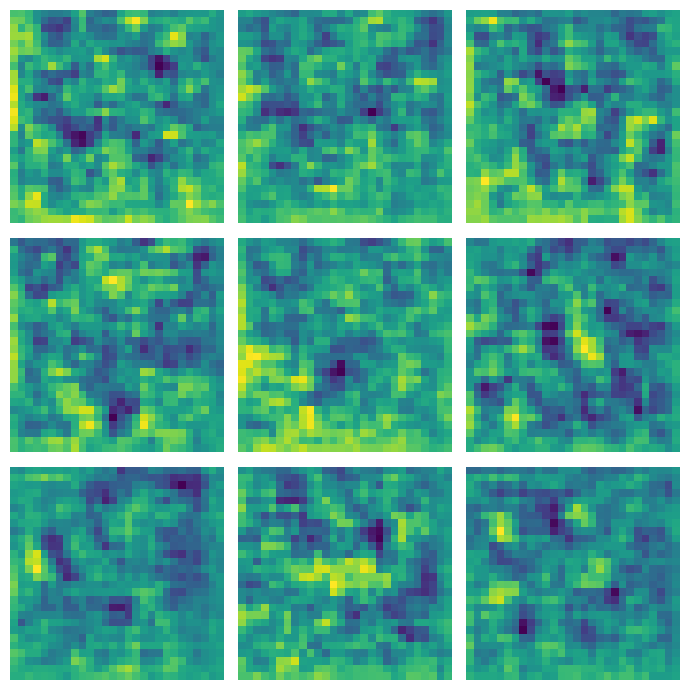

In [5]:

plt.figure(figsize=(7,7))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    img = gen.predict(np.random.randn(1,192,1)) # 1 is the number of images that is generated (batch size), (192, 1) is the array of 192 random values that our generator expects
    plt.imshow(np.squeeze(img))
    plt.axis(False)

plt.tight_layout()
plt.show()

# Discriminator NN

In [6]:
def build_discriminator():
    discriminator = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, (5,5), input_shape=[28,28,1], activation="leaky_relu"),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(128, (5,5), activation="leaky_relu"),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(128, (5,5), activation="leaky_relu"),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(64, (5,5), activation="leaky_relu"),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(32, (5,5), activation="leaky_relu"),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    return discriminator

disc = build_discriminator()
disc.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 20, 20, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 64)     │       204,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 32)       │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 874,465 (3.34 MB)

 Trainable params: 874,465 (3.34 MB)

 Non-trainable params: 0 (0.00 B)

The discriminator is essentially an image classifier; therefore, its architecture *resembles that of a standard CNN*.

The first Conv2D layer expects an input of **(28, 28, 1)** because that is the output of our generator. Essentially, the discriminator receives the images generated by the generator and predicts whether they are generated images or not. *The Dropout layer helps us avoid overfitting by randomly deactivating a portion of the filters during training.* The input parameter of **0.25** indicates that 25% of the filters will be randomly deactivated during the forward pass.

These types of layers are repeated multiple times, as seen in a typical CNN image classifier. In the end, the layers are flattened into a single dense layer, which is then connected to a single neuron that indicates whether the image is generated or not.

# Custom training loop


In [7]:
gen_opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
disc_opt = tf.keras.optimizers.Adam(learning_rate=0.00001 )

gen_loss = tf.keras.losses.BinaryCrossentropy()
disc_loss = tf.keras.losses.BinaryCrossentropy()

In [8]:
from tensorflow.keras.models import Model

class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.generator = generator
        self.discriminator = discriminator

    def compile(self, gen_opt, disc_opt, gen_loss, disc_loss, *args, **kwargs):
        super().compile(*args, **kwargs)

        self.gen_opt = gen_opt
        self.disc_opt = disc_opt
        self.gen_loss = gen_loss
        self.disc_loss = disc_loss

    def train_step(self, batch):
        real_images = batch
        generated_images = self.generator(tf.random.normal((batch_size, 192, 1)), training=False)

        # Training the discriminator
        with tf.GradientTape() as d_tape:
            real_image_output = self.discriminator(real_images, training=True)
            generated_image_output = self.discriminator(generated_images, training=True)
            discriminator_predictions = tf.concat([real_image_output, generated_image_output], axis=0)

            # Labels for real and fake image
            discriminator_labels = tf.concat([tf.zeros_like(real_image_output), tf.ones_like(generated_image_output)], axis=0)

            # Noise added to our labels
            noise_real_image_output = 0.15*tf.random.uniform(tf.shape(real_image_output))
            noise_generated_image_output = -0.15*tf.random.uniform(tf.shape(generated_image_output))
            discriminator_labels += tf.concat([noise_real_image_output, noise_generated_image_output], axis=0)

            # Loss calculation
            total_disc_loss = self.disc_loss(discriminator_labels, discriminator_predictions)

            #Backprop
            disc_grads = d_tape.gradient(total_disc_loss, self.discriminator.trainable_variables)
            self.disc_opt.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        # Training the generator
            with tf.GradientTape() as g_tape:
                new_generated_images = self.generator(tf.random.normal((batch_size, 192, 1)), training=True)
                generator_predictions = self.discriminator(new_generated_images, training=False)

                total_gen_loss = self.gen_loss(tf.zeros_like(generator_predictions), generator_predictions)

                gen_grads = g_tape.gradient(total_gen_loss, self.generator.trainable_variables)
                self.gen_opt.apply_gradients(zip(gen_grads, self.generator.trainable_variables))

            return {"discriminator loss": total_disc_loss,"generator loss": total_gen_loss}


In a custom training loop, we create a class that inherits from the base model class, which provides significant control over TensorFlow's behavior. This enables us to write a custom training loop tailored to our needs.

There are three main methods that we need to define in this class: **init**, **compile**, and **train_step** (which replaces the standard fit method).

In the **init** method, we pass in our discriminator and generator models, along with any additional arguments (args and kwargs) from the parent class. We then initialize both the generator and discriminator within this method.

The **compile** method is where we pass the optimizers and loss functions that we defined for both the discriminator and generator, as well as any additional arguments from the parent class's compile method. This allows us to set up the optimizers and loss functions for training.

In the **train_step** method, we take the current batch of data as input and initialize the real images. We then generate fake images using our generator, ensuring to set **training=False** since we are just predicting at this step. To train the models, we using tf.GradientTape API, which allows us to compute gradients with respect to all trainable variables. The training is then divided into two parts: **discriminator training** and **generator training**.

### Discriminator Training
First, we pass both the real and fake images (generated by the generator) through the discriminator, obtaining predictions for both. We then concatenate these predictions into a variable named **discriminator_predictions**. Next, we generate labels for the discriminator by concatenating a matrix of zeros (representing real images) and a matrix of ones (representing fake images). We assign real images a label of 0 and fake images a label of 1, as we want the discriminator to spot the fake images.

To prevent the discriminator from becoming overconfident, we introduce some **noise** into the predictions. This technique smooths decision boundaries, prevents mode collapse, and improves generalization by giving better gradient signals to the generator.

We compute the loss using the **disc_loss** function defined earlier. Finally, we calculate the gradients with respect to each trainable variable using the tf.GradientTape API, and the optimizer applies these gradients to update the discriminator’s parameters, minimizing the loss. This process pairs each gradient with its corresponding trainable variable for efficient backpropagation.

### Generator training
In the generator training phase, we begin by generating some fake images using the generator and setting **training=True**. We then pass these generated images through the discriminator, ensuring to set **training=False** here to prevent the discriminator from learning during the generator's training. The objective is for the generator to produce images that can successfully deceive the discriminator.

Next, we calculate the generator’s loss using the **gen_loss** function. It's important to note that we want to reward the generator for successfully "faking out" the discriminator by classifying the generated images as real (with a label of 0). This encourages the generator to learn how to create more realistic images. Finally, similar to the discriminator, we calculate the gradients using tf.GradientTape, and the optimizer applies these gradients to update the generator’s parameters, enhancing the generator’s ability to produce convincing images.

# Custom Callback to Monitor Training


In [9]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=192, save_img_every=5, save_weights_every=150):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.save_img_every = save_img_every
        self.save_weights_every = save_weights_every
        self.save_dir = '/Users/abdulbari/Desktop/ML/fashiongan'

        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.save_img_every == 0:
          random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
          generated_images = self.model.generator(random_latent_vectors)
          generated_images *= 255
          generated_images.numpy()
          for i in range(self.num_img):
              img = array_to_img(generated_images[i])
              img.save(os.path.join(self.save_dir, f"image_{epoch}_{i}.png"))

        if epoch % self.save_weights_every == 0:
            model_save_path = os.path.join(self.save_dir, f"gan_weights_epoch_{epoch}.weights.h5")
            self.model.generator.save_weights(model_save_path)
            print(f"Model weights saved to {model_save_path}")


## Initialization Method
In the __init__ method, we initialize key parameters for the monitoring process. The **num_img** parameter specifies the number of images to generate and save after every defined interval. The **latent_dim** parameter defines the dimensionality of the random latent vectors used for generating images. Additionally, **save_img_every** sets the frequency (in epochs) at which images are saved, while **save_weights_every** determines how often the model weights are saved during training. We also define a directory path, **save_dir**, where all generated images and saved weights will be stored. If this directory does not exist, it is created to ensure that the images and weights have a designated storage location.

## On Epoch End Method
The core functionality of the class lies in the **on_epoch_end** method, which is automatically called at the end of each training epoch.

  1. Image Generation and Saving: If the current epoch is a multiple of **save_img_every**, the method generates a set of random latent vectors and uses the generator model to create synthetic images. These generated images are then scaled to a range of 0 to 255 (as images are typically represented) and saved in the specified directory with unique filenames that include the epoch number.

  2. Weights Saving: Similarly, if the current epoch is a multiple of **save_weights_every**, the model's generator weights are saved to the specified directory with a filename that includes the epoch number. This enables the model to be restored or analyzed at various training stages, allowing for better tracking of the model's performance and improvements over time.

By implementing this monitoring class, users can easily visualize the generator's progress and retain important model states throughout the training process, facilitating experimentation and debugging in the GAN training workflow.

In [10]:
fashion = FashionGAN(gen, disc)

In [ ]:
fashion.compile(gen_opt, disc_opt, gen_loss, disc_loss)

steps_per_epoch = 60000 // batch_size
history = fashion.fit(dataset, epochs=300, steps_per_epoch=steps_per_epoch , callbacks=[ModelMonitor()])

# Visualising the Trained Generated Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


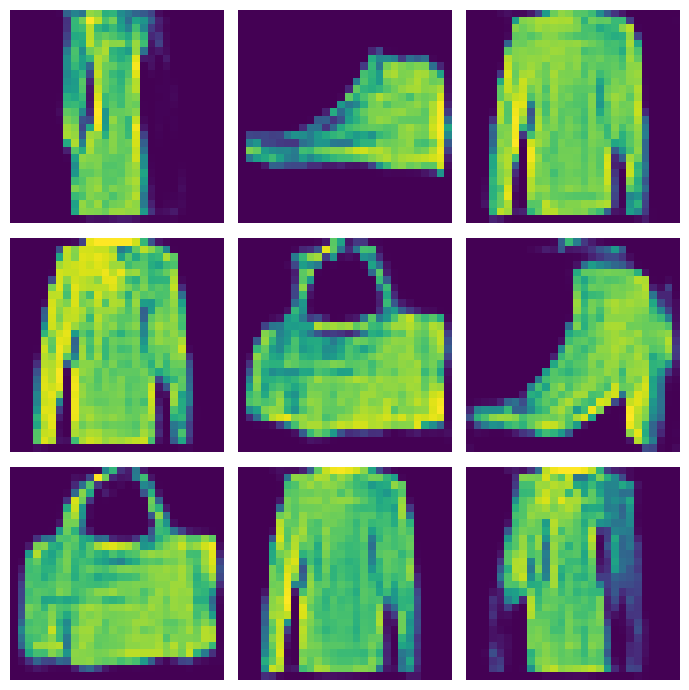

In [22]:
gen.load_weights("/Users/abdulbari/Desktop/ML/fashiongan/weights/gan_weights_epoch_300.weights.h5")
plt.figure(figsize=(7,7))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    img = gen.predict(tf.random.normal((1, 192, 1))) # 1 is the number of images that is generated (batch size), (192, 1) is the array of 192 random values that our generator expects
    plt.imshow(np.squeeze(img))
    plt.axis(False)

plt.tight_layout()
plt.show()